NAME   : REDDIVARI SAI SARAN
Gnumber: G01142501

In [2]:
%%bash
wget -q https://repo.vse.gmu.edu/DataScience/apache.access.log

In [3]:
import os
import sys
import re
import datetime
import findspark
findspark.init('/opt/spark')
from pyspark.sql import functions as F

In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
sc = SparkContext()
sc.stop()
sqlContext = SQLContext(sc)

In [5]:
data = sqlContext.read.text('apache.access.log')

In [6]:
print(data.count())

1043177


In [7]:
print(data.printSchema())

root
 |-- value: string (nullable = true)

None


In [8]:
data.show(n=7,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                     |
+--------------------------------------------------------------------------------------------------------------------------+
|in24.inetnebr.com - - [01/Aug/1995:00:00:01 -0400] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt HTTP/1.0" 200 1839|
|uplherc.upl.com - - [01/Aug/1995:00:00:07 -0400] "GET / HTTP/1.0" 304 0                                                   |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/ksclogo-medium.gif HTTP/1.0" 304 0                          |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/MOSAIC-logosmall.gif HTTP/1.0" 304 0                        |
|uplherc.upl.com - - [01/Aug/1995:00:00:08 -0400] "GET /images/USA-logosmall.gif HTTP/1.0" 304 0                           |


In [9]:
split_df = data.select(
  # \s = whitespace char, \d = digit char [0-9], \w = word char
  # 'host' field: ([^\s]+\s) means take group who DOESN'T begin with whitespace char, and regex stop when it encounters \s
  F.regexp_extract('value', r'^([^\s]+\s)', 1).alias('host'),
  # 'timestamp' field: capture group whose enclosed by bar bracket [] - parenthesis doesn't cover the bar-brack cuz you just want the timestamp.
  #                    it goes like: "2-dig/3-alpha/4-dig/2dig:2dig:2dig: -3dig"
  F.regexp_extract('value', r'^.*\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]', 1).alias('timestamp'),
  # 'path' field: ^.*" = take any char until you hit the double-quote char.  \w+\s = http request method.
  #               Finally, ([^\s]+)\s+HTTP = keep extracing all non-whitespace char until you bump into \s followed up HTTP
  F.regexp_extract('value', r'^.*"\w+\s+([^\s]+)\s+HTTP.*"', 1).alias('path'),
  # 'status' field: http://www.w3schools.com/tags/ref_httpmessages.asp
  F.regexp_extract('value', r'^.*"\s+([^\s]+)', 1).cast('integer').alias('status'),
  # 'content_size' field: the ending series of digits
  F.regexp_extract('value', r'^.*\s+(\d+)$', 1).cast('integer').alias('content_size'))
split_df.show(n=5,truncate=False)

+------------------+--------------------------+-----------------------------------------------+------+------------+
|host              |timestamp                 |path                                           |status|content_size|
+------------------+--------------------------+-----------------------------------------------+------+------------+
|in24.inetnebr.com |01/Aug/1995:00:00:01 -0400|/shuttle/missions/sts-68/news/sts-68-mcc-05.txt|200   |1839        |
|uplherc.upl.com   |01/Aug/1995:00:00:07 -0400|/                                              |304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/images/ksclogo-medium.gif                     |304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/images/MOSAIC-logosmall.gif                   |304   |0           |
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/images/USA-logosmall.gif                      |304   |0           |
+------------------+--------------------------+-------------------------

In [10]:
cleaned_df = split_df.na.fill({'content_size': 0})

In [11]:
month_map = {
  'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7,
  'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12
}

def parse_clf_time(s):
    """ Convert Common Log time format into a Python datetime object
    Args:
        s (str): date and time in Apache time format [dd/mmm/yyyy:hh:mm:ss (+/-)zzzz]
    Returns:
        a string suitable for passing to CAST('timestamp')
    """
    # NOTE: We're ignoring time zone here. In a production application, you'd want to handle that.
    return "{0:04d}-{1:02d}-{2:02d} {3:02d}:{4:02d}:{5:02d}".format(
      int(s[7:11]),
      month_map[s[3:6]],
      int(s[0:2]),
      int(s[12:14]),
      int(s[15:17]),
      int(s[18:20])
    )

u_parse_time = F.udf(parse_clf_time)

In [12]:
col_to_append = (u_parse_time(cleaned_df['timestamp'])
                 .cast('timestamp') # convert column type. https://wtak23.github.io/pyspark/generated/generated/sql.Column.cast.html
                 .alias('time')     # rename
                )
print(col_to_append)

Column<CAST(parse_clf_time(timestamp) AS TIMESTAMP) AS `time`>


In [13]:
# now append column to our parsed, cleaned dataframe
logs_df = cleaned_df.select('*', col_to_append)
logs_df.show(n=5,truncate=False)

+------------------+--------------------------+-----------------------------------------------+------+------------+-------------------+
|host              |timestamp                 |path                                           |status|content_size|time               |
+------------------+--------------------------+-----------------------------------------------+------+------------+-------------------+
|in24.inetnebr.com |01/Aug/1995:00:00:01 -0400|/shuttle/missions/sts-68/news/sts-68-mcc-05.txt|200   |1839        |1995-08-01 00:00:01|
|uplherc.upl.com   |01/Aug/1995:00:00:07 -0400|/                                              |304   |0           |1995-08-01 00:00:07|
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/images/ksclogo-medium.gif                     |304   |0           |1995-08-01 00:00:08|
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/images/MOSAIC-logosmall.gif                   |304   |0           |1995-08-01 00:00:08|
|uplherc.upl.com   |01/Aug/1995:00:00:08 -0400|/

In [14]:
logs_df = logs_df.drop('timestamp')
logs_df.show(n=5,truncate=False)

+------------------+-----------------------------------------------+------+------------+-------------------+
|host              |path                                           |status|content_size|time               |
+------------------+-----------------------------------------------+------+------------+-------------------+
|in24.inetnebr.com |/shuttle/missions/sts-68/news/sts-68-mcc-05.txt|200   |1839        |1995-08-01 00:00:01|
|uplherc.upl.com   |/                                              |304   |0           |1995-08-01 00:00:07|
|uplherc.upl.com   |/images/ksclogo-medium.gif                     |304   |0           |1995-08-01 00:00:08|
|uplherc.upl.com   |/images/MOSAIC-logosmall.gif                   |304   |0           |1995-08-01 00:00:08|
|uplherc.upl.com   |/images/USA-logosmall.gif                      |304   |0           |1995-08-01 00:00:08|
+------------------+-----------------------------------------------+------+------------+-------------------+
only showing top 5 

In [15]:
total_log_entries = logs_df.count()
print(total_log_entries)

1043177


In [16]:
logs_df.printSchema()

root
 |-- host: string (nullable = true)
 |-- path: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- content_size: integer (nullable = false)
 |-- time: timestamp (nullable = true)



In [17]:
logs_df.show()

+--------------------+--------------------+------+------------+-------------------+
|                host|                path|status|content_size|               time|
+--------------------+--------------------+------+------------+-------------------+
|  in24.inetnebr.com |/shuttle/missions...|   200|        1839|1995-08-01 00:00:01|
|    uplherc.upl.com |                   /|   304|           0|1995-08-01 00:00:07|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|/images/launch-lo...|   200|        1713|1995-08-01 00:00:09|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|1995-08-01 00:00:10|
|slppp6.intermind....|/history/skylab/s...|   200|        1687|1995-08-01 00:00:10|
|piweba4y.prodigy....|/images/launchmed...|   200|       11853|1995-08-01 00

### Write your code below. 
##### Few hints
##### 1. Use logs_df to answer the questions.
##### 2. For visualization, convert your data to Pasdas DataFrame first.
##### -----

Q1: Show the content_size Statistics using describe method (5 points)

In [18]:
df=logs_df
df.show()

+--------------------+--------------------+------+------------+-------------------+
|                host|                path|status|content_size|               time|
+--------------------+--------------------+------+------------+-------------------+
|  in24.inetnebr.com |/shuttle/missions...|   200|        1839|1995-08-01 00:00:01|
|    uplherc.upl.com |                   /|   304|           0|1995-08-01 00:00:07|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|1995-08-01 00:00:08|
|ix-esc-ca2-07.ix....|/images/launch-lo...|   200|        1713|1995-08-01 00:00:09|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|1995-08-01 00:00:10|
|slppp6.intermind....|/history/skylab/s...|   200|        1687|1995-08-01 00:00:10|
|piweba4y.prodigy....|/images/launchmed...|   200|       11853|1995-08-01 00

In [19]:
df.describe('content_size').show()

+-------+------------------+
|summary|      content_size|
+-------+------------------+
|  count|           1043177|
|   mean|17531.555702435926|
| stddev|  68561.9990626412|
|    min|                 0|
|    max|           3421948|
+-------+------------------+



Q2: Count each status (hint: Use groupby and count). Also sort the output by status (5 points)

In [55]:
df1=df.groupby("status").count()

In [80]:
df1.show()

+------+------+
|status| count|
+------+------+
|   501|    17|
|   500|     2|
|   403|    58|
|   404|  6185|
|   200|940847|
|   304| 79824|
|   302| 16244|
+------+------+



Q3: Display the about output using Bar graph. (Hint: Use matplotlib library) (5 points)

In [60]:
import matplotlib.pyplot as plt

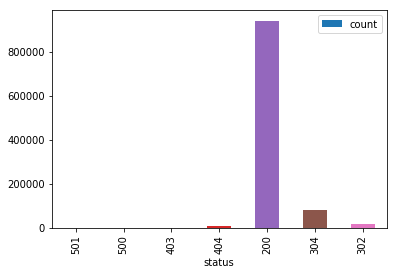

In [34]:
import pandas as pd 

df=pd.DataFrame({'status':[501,500,403,404,200,304,302],'count':[17,2,58,6185,940847,79824,16244]})
df.plot.bar(x='status',y='count')


Q4: Get all hosts that has accessed the server more than 10 times. Show 15 hosts as an output (5 points)

In [86]:
host_sum_df =(df.groupBy('host').count())

host_sum_df.show()

+--------------------+-----+
|                host|count|
+--------------------+-----+
| grail911.nando.net |    8|
|prakinf2.prakinf....|   96|
| alpha2.csd.uwm.edu |   81|
|cjc07992.slip.dig...|   16|
|n1377004.ksc.nasa...|  227|
|      163.205.2.134 |   78|
|huge.oso.chalmers...|  237|
|    198.180.132.201 |    2|
|      163.205.44.27 |   60|
|    dial17.irco.com |    1|
| marple.harvard.edu |    2|
| shark.ksc.nasa.gov |   26|
|    xyplex16.uio.no |    6|
| etc5.etechcorp.com |   11|
|dd07-029.compuser...|   18|
|    131.182.101.161 |   64|
|ip-ts2-131.neca.com |    6|
|     134.95.100.201 |   15|
|        194.20.24.3 |    3|
|     143.166.206.88 |    5|
+--------------------+-----+
only showing top 20 rows



In [93]:
more_than_10_df = (host_sum_df
                        .filter(host_sum_df['count'] > 10)
                        .select(host_sum_df['host']))
more_than_10_df.show(15)

+--------------------+
|                host|
+--------------------+
|prakinf2.prakinf....|
| alpha2.csd.uwm.edu |
|cjc07992.slip.dig...|
|n1377004.ksc.nasa...|
|      163.205.2.134 |
|huge.oso.chalmers...|
|      163.205.44.27 |
| shark.ksc.nasa.gov |
| etc5.etechcorp.com |
|dd07-029.compuser...|
|    131.182.101.161 |
|     134.95.100.201 |
|vab08.larc.nasa.gov |
|       ip11.iac.net |
|ad11-012.compuser...|
+--------------------+
only showing top 15 rows



Q5: Show top 10 path based on their count (hint: Use groupby and count) (5 points)

In [94]:
paths_df = (df.groupBy('path').count().sort('count', ascending=False))

paths_df.show()

+--------------------+-----+
|                path|count|
+--------------------+-----+
|/images/NASA-logo...|59666|
|/images/KSC-logos...|50420|
|/images/MOSAIC-lo...|43831|
|/images/USA-logos...|43604|
|/images/WORLD-log...|43217|
|/images/ksclogo-m...|41267|
|           /ksc.html|28536|
|/history/apollo/i...|26766|
|/images/launch-lo...|24742|
|                   /|20173|
|/images/ksclogosm...|18955|
|/shuttle/missions...|17383|
|/shuttle/missions...|16155|
|/shuttle/missions...|15819|
| /shuttle/countdown/|15740|
|/shuttle/missions...|15214|
|/images/launchmed...|13930|
|     /icons/menu.xbm| 8704|
|    /icons/blank.xbm| 8653|
|    /icons/image.xbm| 7504|
+--------------------+-----+
only showing top 20 rows



In [95]:
paths_df.show(10)

+--------------------+-----+
|                path|count|
+--------------------+-----+
|/images/NASA-logo...|59666|
|/images/KSC-logos...|50420|
|/images/MOSAIC-lo...|43831|
|/images/USA-logos...|43604|
|/images/WORLD-log...|43217|
|/images/ksclogo-m...|41267|
|           /ksc.html|28536|
|/history/apollo/i...|26766|
|/images/launch-lo...|24742|
|                   /|20173|
+--------------------+-----+
only showing top 10 rows



Difficulty: Intermediate

Q6: What are the top ten paths which do not return code 200? Hint: Create a sorted list containing the paths and the number of times that they were accessed (counts) with a non 200 return code and show the top ten paths with their counts. (Use groupby and count) (5 points)

In [97]:
from pyspark.sql.functions import desc
df2 = df.filter(logs_df['status'] != '200')

df2.show(10)

+--------------------+--------------------+------+------------+-------------------+
|                host|                path|status|content_size|               time|
+--------------------+--------------------+------+------------+-------------------+
|    uplherc.upl.com |                   /|   304|           0|1995-08-01 00:00:07|
|    uplherc.upl.com |/images/ksclogo-m...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/USA-logos...|   304|           0|1995-08-01 00:00:08|
|    uplherc.upl.com |/images/WORLD-log...|   304|           0|1995-08-01 00:00:10|
|    uplherc.upl.com |/images/NASA-logo...|   304|           0|1995-08-01 00:00:14|
|kgtyk4.kj.yamagat...|/images/NASA-logo...|   304|           0|1995-08-01 00:00:21|
|kgtyk4.kj.yamagat...|/images/MOSAIC-lo...|   304|           0|1995-08-01 00:00:21|
|kgtyk4.kj.yamagat...|/images/USA-logos...|   304|           0|1995-08-01 00

In [98]:
sum_df = df2.groupBy('path').count().sort('count', ascending=False)

In [99]:
sum_df.show(10, False)

+---------------------------------------+-----+
|path                                   |count|
+---------------------------------------+-----+
|/images/NASA-logosmall.gif             |8761 |
|/images/KSC-logosmall.gif              |7236 |
|/images/MOSAIC-logosmall.gif           |5197 |
|/images/USA-logosmall.gif              |5157 |
|/images/WORLD-logosmall.gif            |5020 |
|/images/ksclogo-medium.gif             |4728 |
|/history/apollo/images/apollo-logo1.gif|2907 |
|/images/launch-logo.gif                |2811 |
|/                                      |2199 |
|/images/ksclogosmall.gif               |1622 |
+---------------------------------------+-----+
only showing top 10 rows



Q7: How many unique hosts are there in the entire log? (5 points)

In [100]:
unique_host = logs_df.select(logs_df['host']).distinct().count()
print 'Unique hosts: {0}'.format(unique_host)

Unique hosts: 54507


Difficulty: Hard

Q8: determine the number of unique hosts in the entire log on a day-by-day basis. Hint: You need to use the dayofmonth function in sql.functions module. https://spark.apache.org/docs/1.6.2/api/java/org/apache/spark/sql/functions.html
Think about the steps that you need to perform to count the number of different hosts that make requests each day. (10 points)

In [101]:
from pyspark.sql.functions import dayofmonth

day_host_pair_df = logs_df.select(logs_df['host'], dayofmonth(logs_df['time']).alias('day'))
day_group_hosts_df = day_host_pair_df.distinct()
daily_hosts_df = day_group_hosts_df.select(day_group_hosts_df['day']).groupBy(day_group_hosts_df['day']).count().cache()

In [102]:
daily_hosts_df.show(30, False)

+---+-----+
|day|count|
+---+-----+
|12 |2864 |
|22 |4456 |
|1  |2582 |
|13 |2650 |
|6  |2537 |
|16 |4340 |
|3  |3222 |
|20 |2560 |
|5  |2502 |
|19 |2550 |
|15 |4214 |
|9  |4317 |
|17 |4385 |
|4  |4190 |
|8  |4406 |
|7  |4106 |
|10 |4523 |
|21 |4134 |
|11 |4346 |
|14 |4454 |
|18 |4168 |
+---+-----+



Q9: Visualize the Number of Unique Daily Hosts above. (Hint: Use matplotlib library) (5 points)

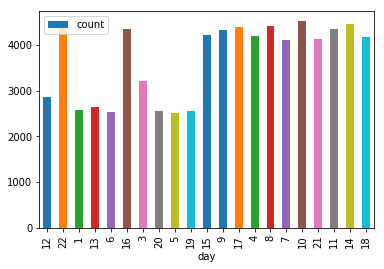

In [35]:
import pandas as pd 

daily_hosts_df= pd.DataFrame({'day':[12,22,1,13,6,16,3,20,5,19,15,9,17,4,8,7,10,21,11,14,18],'count':[2864,4456,2582,2650,2537,4340,3222,2560,2502,2550,4214,4317,4385,4190,4406,4106,4523,4134,4346,4454,4168]})
daily_hosts_df.plot.bar(x='day',y='count')